In [3]:
import numpy as np
import matplotlib.pyplot as plt
from numba import njit
import random
from copy import copy
import tqdm
import dask
import scipy.integrate as integrate
import urllib


## Solving the Langevin Equation in a double-well potential

Our system is described by two stochastic differential equations:

\begin{align}
\dot{v}(t) &= \frac{F(x(t))}{m} -\gamma v(t) + \sqrt{\frac{2\gamma}{k_BT}}\frac{dW}{dt}\\
\dot{x}(t) &= v(t)
\end{align}

the force is given py the gradient of the potential: $F(x) = -\partial_x V(x)$

Following Leimkuhler et al. (2013), we split the numerical integration step for a time dt into 5 distinct parts:

- B: Calculate the determistic velocity at dt/2: $v(t+dt/2) = v(t) + F(x(t))/m dt$
- A: Calculate the position at dt/2: $x(t + dt/2) = x(t) + v(t+dt/2)dt/2$
- O: Add a random value to the velocity (Ornstein-Uhlenbeck): $v_O(t+dt/2) = \exp(-\gamma dt) v(t+dt/2) + dW \sqrt{(1-\exp(-2\gamma dt))k_BT}$
- A: x(t+dt) = $x(t+dt/2) + v_O(t+dt/2)dt/2$
- B: v(t+dt) = $v_O(t+dt/2) + dtF(x(t))/m$


In [7]:
@njit
def le_single_time_step(m, gamma, kbt, potential, x, v, dt):
    def update_position(x, v, dt):
        return x + v * dt

    def update_velocity(v, F, dt):
        return v + F/m * dt

    def update_random_velocity(v, gamma, dt):
        R = np.random.normal()
        c1 = np.exp(-gamma*dt)
        c2 = np.sqrt(1-c1*c1)*np.sqrt(kbt)
        return c1*v + R*c2

    # B
    _, force = potential(x)
    v = update_velocity(v, force, dt/2)

    # A
    x = update_position(x, v, dt/2)

    # O
    v = update_random_velocity(v, gamma, dt/2)

    # A
    x = update_position(x, v, dt/2)

    # B
    v = update_velocity(v, force, dt/2)

    return x, v


### Double Well Potential


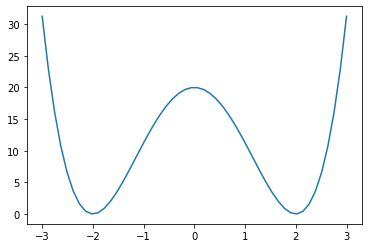

In [17]:
@njit
def double_well_potential(x, k=5, a=2):
    energy = 0.25*k*((x-a)**2) * ((x+a)**2)
    force = -k*x*(x-a)*(x+a)
    return energy, force


# plot the potential
interval = np.linspace(-3, 3)
plt.plot(interval, double_well_potential(interval)[0])
plt.show()


In [81]:

@njit
def my_step_function(state, dt):
    gamma = 1
    kbt = 1
    m = 1

    x = state[0]
    v = state[1]

    return le_single_time_step(m, gamma, kbt, double_well_potential, x, v, dt)


In [82]:

@njit
def solve(step_func, initial_state, t_max, dt, save_interval):
    t = 0
    state = initial_state
    results = [state]
    times = [t]
    last_save = t

    while t < t_max:

        state = step_func(state, dt)

        t = t + dt

        if t - last_save >= save_interval:
            results.append(state)
            times.append(t)
            last_save = t

    return times, results


<function matplotlib.pyplot.show(close=None, block=None)>

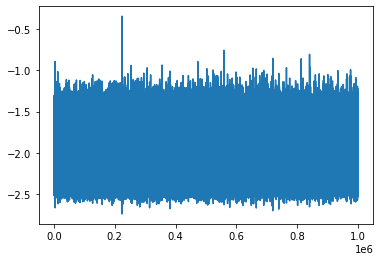

In [83]:
initial = (-2, 0)
times, states = solve(my_step_function, initial, 1e6, 1e-3, 1e-1)

plt.plot(times, list(zip(*states))[0])
plt.show


In [84]:
ops = list(zip(*states))[0][:20000]
np.percentile(ops, 99.95)


-1.3964405543419645

## Forward flux sampling

We'll implement direct FFS (DFFS):

1. Start trajectory in A, run simulation until $\lambda_0$ is crossed $N$ times in forward direction. Save configurations at crossing
2. Start $k_0$ trajectories at $\lambda_0$ by randomly choosing starting points from the previously saved configurations. Run until they reach next $\lambda$ (success, save configuration) or return to $\lambda_0$ (failure).
3. Repeat step 2 from all $\lambda_i$ until we reach $\lambda_n$


### Compute trajectory from initial state


In [38]:

@njit
def solve_initial_trajectory(
    step_func,  # function to make integration time step
    initial_state,
    calculate_op,  # function to caculate order parameter
    lambda0,
    max_crossings,
    dt,
    t_max,
    save_interval
):
    crossings = 0
    state = initial_state
    t = 0
    times = [t]
    results = [state]
    last_save = t
    prev_op = calculate_op(initial_state)

    while crossings < max_crossings:
        state = step_func(state, dt)
        t = t + dt

        if t >= t_max:
            raise StopIteration("Computation timed out")

        elif t - last_save >= save_interval:
            results.append(state)
            times.append(t)
            last_save = t
            op = calculate_op(state)

            if prev_op < lambda0 and op >= lambda0:
                crossings += 1

            prev_op = calculate_op(state)

    return times, results


### Compute trajectory from previous to next $\lambda$


In [39]:
@njit
def solve_until_stop(step_func, initial_state, calculate_op, op_min, op_max, dt, t_max, save_interval):
    state = initial_state
    t = 0
    times = [t]
    results = [state]
    last_save = t
    prev_op = calculate_op(initial_state)

    while True:
        state = step_func(state, dt)
        t = t + dt

        if t > t_max:
            raise StopIteration("Computation timed out.")

        elif t - last_save >= save_interval:
            results.append(state)
            times.append(t)
            last_save = t
            op = calculate_op(state)

            if prev_op < op_max and op >= op_max:
                break

            elif prev_op > op_min and op <= op_min:
                break

            prev_op = calculate_op(state)

    return times, results


def sample_next_interface(step_func, initial_states, calculate_op, op_min, op_max, num_crossings, dt, t_max, save_interval):

    def compute_successful_traj(initial_states, step_func=step_func, calculate_op=calculate_op, op_min=op_min, op_max=op_max, dt=dt,
                                t_max=t_max, save_interval=save_interval):

        success = False
        trials = 0
        while success is False:
            trials += 1
            initial_state = random.choice(initial_states)
            times, states = solve_until_stop(
                step_func, initial_state, calculate_op, op_min, op_max, dt, t_max, save_interval)

            op = calculate_op(states[-1])

            if op >= op_max:
                success = True

        return trials, states

    results = []
    for i in range(num_crossings):
        result = compute_successful_traj(initial_states)
        results.append(result)

    # results = compute(results)

    trials = 0
    successful_trajs = []
    for item in results:
        trials = trials + item[0]
        successful_trajs.append(item[1])

    crossing_prob = len(successful_trajs)/trials

    return crossing_prob, successful_trajs


### Run FFS and compute total flux from initial to final state


In [40]:
def ffs_run_all_steps(parameters, step_function, calculate_op, initial_state):

    lambda0 = parameters["interfaces"][0]
    max_crossings = parameters["number of crossings"]
    dt = parameters["integration time step"]
    t_max = parameters["max simulation time"]
    save_interval = parameters["save interval"]

    times, states = solve_initial_trajectory(
        step_function, initial_state, calculate_op, lambda0, max_crossings, dt, t_max, save_interval)

    new_initial_states = []
    for i in range(1, len(states)):
        prev_op = calc_op(states[i-1])
        op = calc_op(states[i])

        if prev_op < lambda0 and op >= lambda0:
            new_initial_states.append(states[i])

    flux = len(new_initial_states)/times[-1]

    probs = []
    traj_collection = []
    for lambd in tqdm.tqdm(parameters["interfaces"][1:]):
        prob, successful_trajs = sample_next_interface(
            step_function, new_initial_states, calculate_op, lambda0, lambd, max_crossings, dt, t_max, save_interval)
        new_initial_states = []

        for traj in successful_trajs:
            new_initial_states.append(traj[-1])

        traj_collection.append(successful_trajs)
        probs.append(prob)

    return flux, probs


In [ ]:

ffs_params = {
    "interfaces": np.arange(-1.75, 2, 0.25),
    "number of crossings": 1000,
    "integration time step": 1e-3,
    "max simulation time": 1e9,
    "save interval": 1e-1
}


@njit
def calc_op(state):
    return state[0]


initial = (-2, 0)

fluxes = []
for i in range(10):
    first_flux, probs = ffs_run_all_steps(
        ffs_params, my_step_function, calc_op, initial)
    print(f"flux through lambda_0:{first_flux}")
    print(f"Subsequent crossing probabailities: {probs}")
    total_flux = first_flux*np.product(probs)
    fluxes.append(total_flux)

print("Mean flux:", np.mean(fluxes))
print("Standard deviation:", np.std(fluxes))


## Analytical calculation of the transition rate

The transition rate can be caculated using transition state theory:

\begin{equation}
k*{TST} = \sqrt{\frac{k_BT}{2m}} \frac{e^{-V(x_0)/(k_BT)}}{\int*{-\infty}^{x_0}dxe^{-V(x)/(k_BT)}}
\end{equation}

For moderate to high friction we add a correction term

\begin{equation}
\kappa = \frac{1}{\omega_0}\left(-\frac{\gamma}{2} + \sqrt{\frac{\gamma^2}{4} + \omega_0^2}\right)
\end{equation}

With $\omega_{a,0} = \sqrt{V''(x_{a,0})/m}$. $x_a$ ist the left minimum and $x_0$ is the maximum at 0.


In [13]:
a = 2
k = 4

gamma = 1
kbt = 1
m = 1


def second_derivative(x, k=k, a=a):
    return k*(3*x**2 - a**2)


omega_0 = np.sqrt(np.abs(second_derivative(0))/m)


def k_tst(kbt=kbt, m=m):
    def boltzmann_factor(x):
        potential, _ = double_well_potential(x)
        return np.exp(-potential/kbt)

    factor1 = np.sqrt(kbt/(2*m))
    factor2 = boltzmann_factor(0)
    integral = integrate.quad(boltzmann_factor, -np.inf, 0)[0]
    return factor1*factor2/integral


k_tst()


1.7733676106528965e-07

### Comparison with results from FFS


In [4]:
file = open(
    "/Users/oleberendes/ownCloud/Localised nucleation/Data/100222-SIM05.txt")

fluxes = []
for line in file:
    arr = np.fromstring(line, sep=" ")
    fluxes.append(np.product(arr))

print(f"Mean flux: {np.mean(fluxes)}")
print(f"Standard deviation: {np.std(fluxes)}")


Mean flux: 8.250402517342914e-08
Standard deviation: 1.8259603609991677e-07


In [5]:
fluxes

[2.1016726010399798e-10,
 2.8052548518983563e-11,
 3.571892758586682e-10,
 2.456983062362869e-07,
 3.206966120679978e-09,
 3.96280041429575e-09,
 1.4016089289118725e-09,
 1.7591721698700505e-07,
 4.2153875751976125e-09,
 1.1740223412929628e-10,
 1.0901693056476058e-11,
 1.8437251196106447e-08,
 4.066486588715791e-07,
 2.3965139023531036e-08,
 1.7988298248494795e-10,
 2.7769187149253276e-09,
 2.138106223430104e-08,
 3.3089200298747575e-09,
 7.381401287888932e-07,
 1.1654235284245366e-10]

**Note**: The more successful trajectories we collect at each interface, the more precise the FFS method becomes. I should collect at least 2000 successful trajectories per interface.